In [1]:
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodecsv as csv
import seaborn as sns
from cycler import cycler
from textwrap import wrap

# Analysize variables.

In [2]:
# Read documentation.
columns_file = r"../records_documentation.txt"

with open(columns_file,"r") as f:
    columns = f.readlines()
columns
        

['[Column 0] ID\n',
 '[Column 1] Birth year: deduced from education history, where available\n',
 '[Column 2] Gender flag: 1=female, 2=male, 0=unknown\n',
 '[Column 3] Skillset1: primary skillset deduced from self-reported skills\n',
 '[Column 4] Skillset1 weight: the extent to which primary skillset is representative of overall self-reported skills\n',
 '[Column 5] Skillset2: secondary skillset deduced from self-reported skills\n',
 '[Column 6] Skillset2 weight: the extent to which secondary skillset is representative of overall self-reported skills\n',
 '[Column 7] City of profile (does not change): where unavailable, the field is left blank\n',
 '[Column 8] Country of Profile (does not change)\n',
 '[Column 9] Education (highest degree attained): 0=none/unknown; 1=high school; 2=vocational degree; 3=associateÕs; 4=bachelorÕs; 5=masterÕs other than MBA; 6=MBA; 7=doctorate (PhD/JD/MD) [NB: Romanian names not covered]\n',
 "[Column 10] Elite institution: a flag indicating whether any o

So:
- Unique identifier: ID.
- Variable Groups:
    - Column 0-10, profile info; 
    - Column 11-28, employment or education info; (c26 = False or True)
        - Column 11-18, general info;
        - Column 19-25, company info;
        - Column 27-28, school info.

In [3]:
# Get unique values for each variable.
empl_file = r"../deloitte_pwc.csv"

unique_values = []
for i in range(33):
    unique_values.append(set())
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, line in enumerate(reader):
        for i in range(33):
            unique_values[i].add(line[i])
for idx, values in enumerate(unique_values):
    print("[Column {}] ".format(idx)+str(len(values)))
        

[Column 0] 1095185
[Column 1] 84
[Column 2] 3
[Column 3] 45
[Column 4] 390501
[Column 5] 45
[Column 6] 390503
[Column 7] 16127
[Column 8] 258
[Column 9] 8
[Column 10] 2
[Column 11] 849
[Column 12] 3
[Column 13] 763
[Column 14] 3
[Column 15] 2
[Column 16] 3246
[Column 17] 2640332
[Column 18] 865
[Column 19] 1767657
[Column 20] 1557541
[Column 21] 10261
[Column 22] 309
[Column 23] 2
[Column 24] 204454
[Column 25] 739
[Column 26] 2
[Column 27] 8
[Column 28] 2
[Column 29] 1469
[Column 30] 68
[Column 31] 7835
[Column 32] 1003970


In [4]:
# One block to convert data to pd.DataFrame.
empl_file = r"../deloitte_pwc.csv"

entries_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, line in enumerate(reader):
        if idx == 5: # Control number of rows.
            break
        entries_lst.append(line)

samples_lst = entries_lst
entries_df = pd.DataFrame(data=entries_lst)
entries_df#.loc[lambda df:df[26]=='True',[17]]


0     1  2                        3   \
0  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   
1  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   
2  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   
3  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   
4  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   

                   4                      5                    6      7   \
0  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   
1  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   
2  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   
3  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   
4  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   

       8  9   ...     23                  24  25     26 27     28 29 30 31  \
0  France  5  ...  False                           True  5  False            
1  France  5  ...  False                           True     False            
2  France  5  ...  False                          False     False            
3  France  5  ...  False                      54  False     False            
4  France  5  ...  False  paris area, france  54  False     False            

              32  
0  1525765406000  
1  1525765406000  
2  1525765406000  
3  1525765406000  
4  1525765406000  

[5 rows x 33 columns]

In [5]:
# Get an example.
entry = samples_lst[2]
for i in range(len(entry)):
    print("[Column {}] ".format(i)+entry[i])

[Column 0] ed3c50a8-d2d3-3809-9d2a-0f53574560aa
[Column 1] 1980
[Column 2] 2
[Column 3] Accounting and Auditing
[Column 4] 0.9292892909340925
[Column 5] Industrial Management
[Column 6] 0.00825650305491638
[Column 7] Paris
[Column 8] France
[Column 9] 5
[Column 10] False
[Column 11] 2004-09-01
[Column 12] True
[Column 13] 2005-06-01
[Column 14] True
[Column 15] False
[Column 16] 273
[Column 17] Financial Controller Assistant,financial controller,assistant
[Column 18] ACCOUNTING
[Column 19] EADS Astrium
[Column 20] EADS Astrium
[Column 21] 
[Column 22] 
[Column 23] False
[Column 24] 
[Column 25] 
[Column 26] False
[Column 27] 
[Column 28] False
[Column 29] 
[Column 30] 
[Column 31] 
[Column 32] 1525765406000


# Aggregate employment changes to the firm-by-date level.

In [6]:
# Read, Identify & Aggregate. - A code to output raw data for reference. Unfinished and unused.
empl_file = r"../deloitte_pwc.csv"

## Initialize.
career_lst = [] # Will contain the entries for the same person.
person_this = None
profile_this = None

## Iterate.
empl_changes_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, entry in enumerate(itertools.chain(reader,[None]*33)):
        if idx == 100: # End point.
            break
        if person_this != entry[0]:
            if career_lst != []:
                ### Analyze.
                career_df = pd.DataFrame(career_lst)
                print(career_df[[0,1,2,3,4,10,14]])
                print(profile_this)
                ####################################################################
                # empl_changes_lst.append()
            ### Re-initialize.
            person_this = entry[0]
            profile_this = entry[1:11]
            career_lst = []
        ### Record this entry.
        if profile_this[2] == 'Accounting and Auditing' and entry[26] == 'False': # only consider accountants.
            career_lst.append(entry[11:29])

#####################################################
# empl_changes_df = pd.DataFrame(empl_changes_lst)
            

           0      1           2      3      4  10  14
0  2004-09-01   True  2005-06-01   True  False       
1  2006-07-01   True  2006-11-01   True  False  P  54
2  2007-01-01   True  2012-10-01   True  False  P  54
3  2012-10-01   True  2016-07-01   True  False     48
4  2017-01-01  False        None  False   True     92
['1980', '2', 'Accounting and Auditing', '0.9292892909340925', 'Industrial Management', '0.00825650305491638', 'Paris', 'France', '5', 'False']
           0      1           2      3      4         10        14
0  2001-01-01  False  2001-12-01  False  False  TIME_OFF  TIME_OFF
1  2002-09-01   True  2003-02-01   True  False         D       561
2  2003-02-01   True  2004-07-01   True  False         D       561
3  2004-09-01   True  2005-02-01   True  False         D       561
4  2005-09-01   True  2008-09-01   True  False         D       561
5  2008-08-01   True  2013-07-01   True  False         D       561
6  2013-07-01   True  2016-11-01   True  False                 

Definition of employment change types: When only employment records are considered, an employment change will be recognized as
- `hiring` if it changed its company to one of the two companies (Deloitte and PwC, hereafter);
- `firing` if it changed its company from one of the two companies to `TIME_OFF` and stayed in `TIME_OFF` for more than 100 days;
- `leaving` if it changed its company from one of the two companies and not recogized as `firing`.

In [7]:
# Define a class to read and process entries.
class entryProcessor:    
    
    def __init__(self, person_id):
        self.person_id = person_id
        self.profile = [None]*6 # "birth_year","gender","primary_skill","country","education_level","f_elite"
        self.employment = [None]*4 # "start_date","end_date","ticker","f_current"
        
    # Three functions to output records.
    # Varlist: Hiring/Leaving/Firing, Ticker, year-month, profile_info: [...], next_industry.
    def enter_record(self):
        return ['hiring',self.employment[2],self.employment[0]]+self.profile+['']    
    def leave_record(self,next_industry):
        return ['leaving',self.employment[2],self.employment[1]]+self.profile+[next_industry]
    def fired_record(self):
        return ['firing',self.employment[2],self.employment[1]]+self.profile+['']
    
    # When id changes, record a possible leave and then clear contents.
    def reinitialize(self,entry):
        if self.employment[3]=="False":
            record = self.leave_record('')
        else:
            record = None
        self.__init__(entry[0])
        self.profile = [entry[x] for x in [1,2,3,8,9,10]]
        return record
    
    # Main method: read and process.
    def read(self,entry):
        record = []
        # Reinitialize when id changes.
        if self.person_id != entry[0]:
            leave_last = self.reinitialize(entry)
            if leave_last is not None:
                record.append(leave_last)
        # Then deal with the current entry.
        if entry[26] == "False":
            if self.employment[2] != entry[21]:
                if self.employment[2] in ['D','P']:
                    if entry[25] == "TIME_OFF" and int(entry[16]) > 100:
                        record.append(self.fired_record())
                    else:
                        record.append(self.leave_record(entry[25]))
                self.employment = [None]*4
                if entry[21] in ['D','P']:
                    self.employment[0] = entryProcessor.convert_time(entry[11],entry[12])
                    self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                    self.employment[2] = entry[21]
                    self.employment[3] = entry[15]
                    record.append(self.enter_record())
            else:
                self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                self.employment[3] = entry[15]
        return record
            
    # Unbound methods.
    def convert_time(date,f_valid_month):
        date_regex = re.match(r"(\d{4})-(\d{2})-\d{2}",date)
        if date_regex is None:
            return None
            #raise ValueError('Not a proper date: {}'.format(date))
        else:
            return date_regex.group(1)+('00' if f_valid_month == 'False' else date_regex.group(2))
        
    # For print.
    def __str__(self):
        return "[person_id: {}, profile: {}, employment: {}]".format(self.person_id, self.profile, self.employment)
            
#entry = entryProcessor(None)
#for i in range(50):
#    print(i)
#    print(entry.read(samples_lst[i]))
#    print(entry)

In [8]:
# Read, Identify & Aggregate.
empl_file = r"../deloitte_pwc.csv"

## Initialize.
career = entryProcessor(None)

## Iterate.
empl_changes_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, entry in enumerate(itertools.chain(reader,[[None]*33])):
        if idx == np.inf: # End point.
            break
        empl_change_this = career.read(entry)
        if empl_change_this != []:
            empl_changes_lst += empl_change_this

varlist = ["type","ticker","yrmth","birth","gender","skill1","cntry","edu","f_elite","ind_next"]
empl_changes_df = pd.DataFrame(data=empl_changes_lst,columns=varlist)
empl_changes_df


type ticker   yrmth birth gender                   skill1  \
0         hiring      P  200607  1980      2  Accounting and Auditing   
1        leaving      P  201210  1980      2  Accounting and Auditing   
2         hiring      D  200800  2000      2                       -1   
3         hiring      P  200307  2000      1                       -1   
4         hiring      D  201103  1976      2                       -1   
5        leaving      D  201207  1976      2                       -1   
6         hiring      D  201309  1984      2                       -1   
7         hiring      P  199800  1967      2                       -1   
8        leaving      P  201305  1967      2                       -1   
9         hiring      D  200209  1978      2  Accounting and Auditing   
10       leaving      D  201307  1978      2  Accounting and Auditing   
11        hiring      D    None  2000      2                       -1   
12       leaving      D  201100  2000      2                       -1   
13        hiring      P  199508  1961      2                       -1   
14       leaving      P  199908  1961      2                       -1   
15        hiring      D  200911  1983      2                       -1   
16       leaving      D  201302  1983      2                       -1   
17        hiring      D  200812  1979      0                       -1   
18       leaving      D  201007  1979      0                       -1   
19        hiring      D  201501  1978      2                       -1   
20        hiring      P  200909  1977      2                       -1   
21       leaving      P  201102  1977      2                       -1   
22        hiring      D  201209  1977      2                       -1   
23       leaving      D  201607  1977      2                       -1   
24        hiring      D  201709  1977      2                       -1   
25        hiring      P  201301  1983      1                       -1   
26        hiring      D  201206  1982      0                       -1   
27       leaving      D  201208  1982      0                       -1   
28        hiring      D  200708  1983      2  Accounting and Auditing   
29       leaving      D  200808  1983      2  Accounting and Auditing   
...          ...    ...     ...   ...    ...                      ...   
1922962  leaving      P  201303  1984      1           Administration   
1922963   hiring      P  201408  1984      1           Administration   
1922964   hiring      D  198600  1962      0  Accounting and Auditing   
1922965   firing      D  199000  1962      0  Accounting and Auditing   
1922966   hiring      D  201106  1985      2                       -1   
1922967  leaving      D  201202  1985      2                       -1   
1922968   hiring      P  201512  1986      1                       -1   
1922969   hiring      P    None  2000      1                       -1   
1922970   hiring      D  201806  1995      2                       -1   
1922971   hiring      P    None  2000      2                       -1   
1922972   hiring      P  201602  1981      2                       -1   
1922973   hiring      P  201301  1991      2                       -1   
1922974   hiring      D  201608  2000      1                 Military   
1922975   hiring      D  201211  1989      0                       -1   
1922976   hiring      P  201503  2000      1                    Legal   
1922977   hiring      P  201805  1978      1                       -1   
1922978   hiring      P  201705  1989      0                       -1   
1922979   hiring      D  201404  1989      0                       -1   
1922980  leaving      D  201604  1989      0                       -1   
1922981   hiring      D    None  2000      0                       -1   
1922982   hiring      P  198700  1966      2                       -1   
1922983   firing      P  199100  1966      2                       -1   
1922984   hiring      D  198910  1968      2                       -1 

# Summarize and plot.

In [9]:
# Styles for the four groups: ('ticker': 'D','P') x ('firing', 'hiring')
line_styles = ['bo-','b^--','b^-','ro-','r^--','r^-']
color_styles = ['skyblue','b','dodgerblue','mistyrose','r','salmon']

# Styles for the two tickers: ('D', 'P')
color_styles_2 = ['b','r']

In [10]:
# Deal with 'yrmth'.
empl_changes_df = empl_changes_df.assign(
    year = lambda df:df.yrmth.apply(lambda x:int(x[:4]) if x is not None else np.nan),
    month = lambda df:df.yrmth.apply(lambda x:int(x[4:]) if x is not None else -1)
)

empl_changes_df.describe(include=[np.object])

type   ticker    yrmth    birth   gender   skill1          cntry  \
count   1922992  1922992  1806162  1922992  1922992  1922992        1922992   
unique        3        2      806       84        3       45            258   
top      hiring        D   201509     2000        2       -1  United States   
freq    1151574   981319    17773   311762   841500  1149928         537757   

            edu  f_elite ind_next  
count   1922992  1922992  1922992  
unique        8        2      648  
top           4    False           
freq     828897  1786115  1454854

## Count the number of employed accountants from Dec., 1989 on.

Note: 
- This block counts the number of currently employed accountants for the two firms by calculating the cumulative sums of the net employment increase, that is, hiring minus the sum of firing and leaving.
- This method is not effective for the early years. However, if we can assure that we have all the resumes of accountants after some time, we will have the correct number after all the accountants employed before that time have left the company. We assume that the number is correct after 1989 except the most recent years.
- All the numbers are counted in the end of the year and will be used to calculate the proportion of the employment changes for next year. Note that we do not calculate monthly employment separately since there are a good proportion of our data with invalid months.

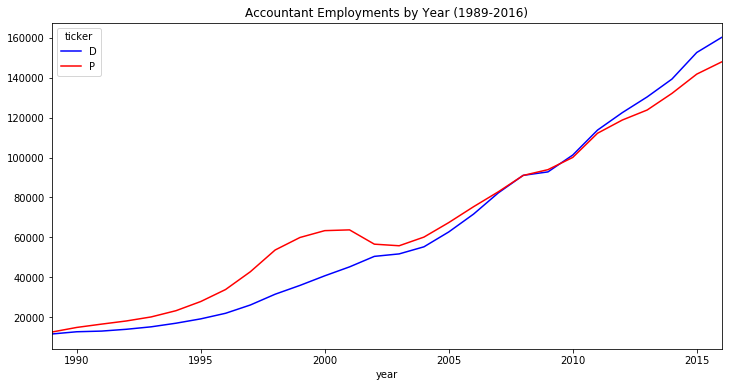

In [11]:
count_by_years = pd.DataFrame({'count':empl_changes_df.groupby(['ticker','type','year']).size()}).reset_index()
empl_by_years = count_by_years.groupby(['ticker','type']).apply(
    lambda df:df.sort_values(['year']).assign(cumsum = lambda df2:df2['count'].cumsum()) # Calculate cumsum.
).reset_index(drop=True).pivot_table(
    index=['ticker','year'],columns='type',values=['cumsum'],fill_value=0 # Reshape to wide format.
).assign(
    employment=lambda df:(df['cumsum']['hiring']-df['cumsum']['firing']-df['cumsum']['leaving']) # Get employment.
).drop('cumsum',axis=1).reset_index()
empl_by_years.columns = empl_by_years.columns.droplevel('type')
empl_by_years.pivot_table(
    index='year',columns='ticker',values='employment'
).loc[lambda df:(df.index>=1989)&(df.index<=2016)].plot(
    figsize=(12,6),color=color_styles_2,title="Accountant Employments by Year (1989-2016)"
)
plt.show()

## Overall trends.
Note: Plots by year and plots by months do not only differ in frequency, but also in sample size. This is due to the entries without valid month record.

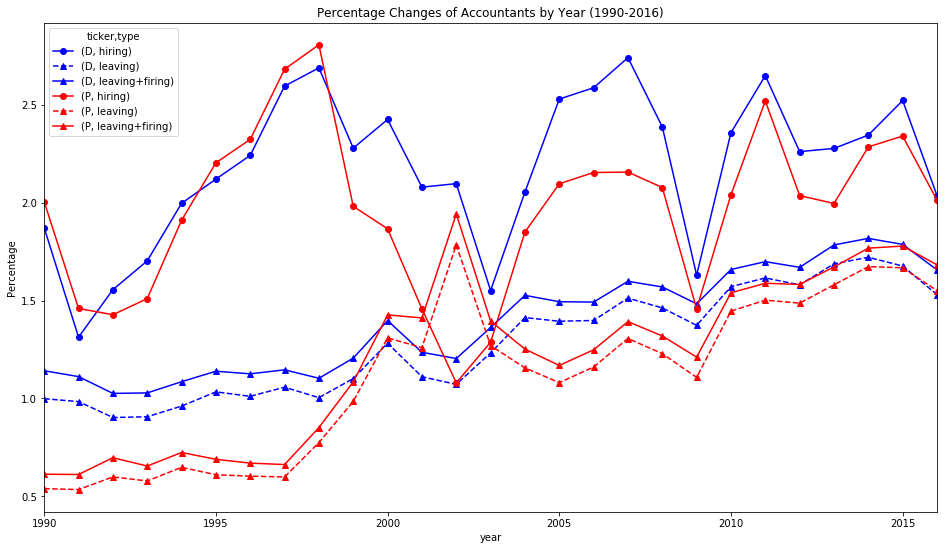

In [12]:
# Count and calculate percentages of employment changes.
prop_by_months = pd.DataFrame(
    {'count':empl_changes_df.groupby(['ticker','type','year','month']).size()} # Count by month.
).reset_index().merge(
    right=empl_by_years.assign(year_1L=lambda df:df.year+1)[['ticker','year_1L','employment']],
    left_on = ['ticker','year'], right_on = ['ticker','year_1L'] # Merge with last year's employment.
).assign(
    prop=lambda df:df['count']/df['employment']*100 # Calculate proportions.
).drop(
    ['count','year_1L','employment'],axis=1 # Drop unnecessary variables.
).loc[lambda df:(df.year>=1990)&(df.year<=2016)] # Keep only [1990, 2016] segment.

# Plot by year.
prop_by_months.pivot_table(
    index = ['ticker','year'], columns = 'type', values = 'prop'
).reset_index().assign(
    **{"leaving+firing":lambda df:(df.leaving+df.firing)}
).pivot_table(
    index='year', columns='ticker', values=['hiring','leaving','leaving+firing']
).reorder_levels(
    ['ticker','type'],axis=1
).sort_index(axis=1).plot(
    style=line_styles, figsize=(16,9), title="Percentage Changes of Accountants by Year (1990-2016)"
).set_ylabel('Percentage')
plt.show()

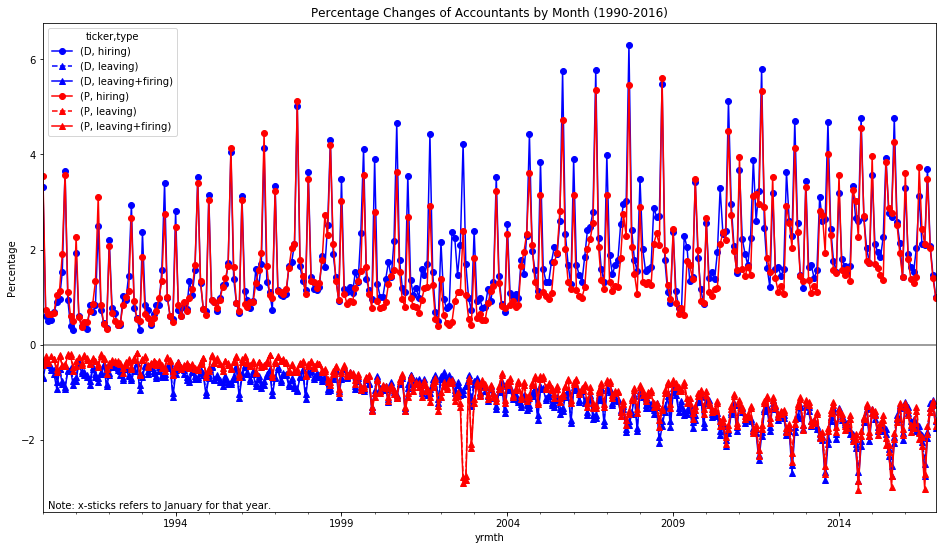

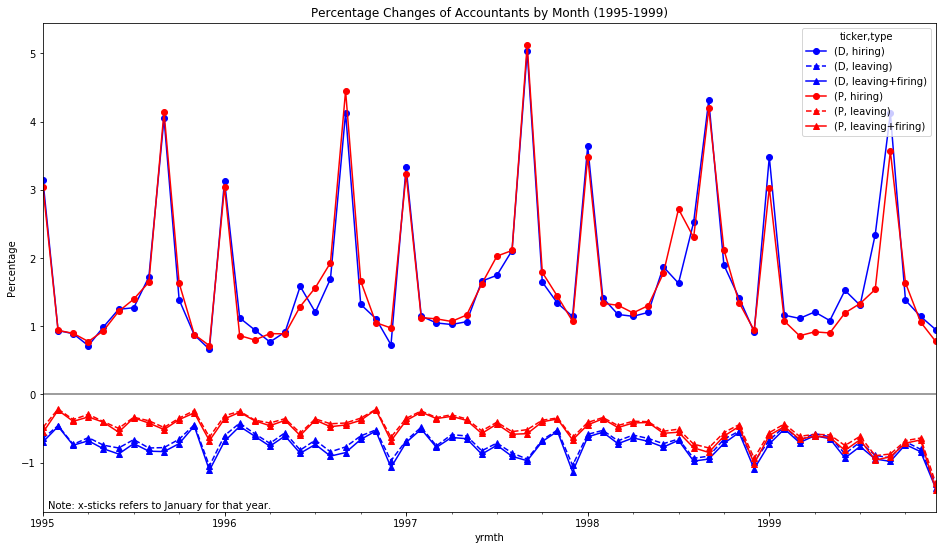

In [13]:
# Plot by month.
## Define a routine for plotting over segments.
def plot_by_month(start_year=1990,end_year=2016):
    prop_by_months.loc[lambda df:(df.month!=0)&(df.year>=start_year)&(df.year<=end_year)].pivot_table(
        index = ['ticker','year','month'], columns='type', values = 'prop'
    ).reset_index().assign(
        **{
            "leaving+firing":lambda df:-(df.leaving+df.firing),
            "leaving":lambda df:-df.leaving,
            "yrmth":lambda df:pd.PeriodIndex(year=df.year,month=df.month,freq='M')
        }
    ).pivot_table(
        index='yrmth', columns='ticker', values=['hiring','leaving','leaving+firing']
    ).reorder_levels(
        ['ticker','type'],axis=1
    ).sort_index(axis=1).plot(
        style=line_styles, figsize=(16,9), 
        title="Percentage Changes of Accountants by Month ({}-{})".format(start_year,end_year)
    ).set_ylabel('Percentage')
    plt.hlines(0,pd.Period('{}-01'.format(start_year)),pd.Period('{}-12'.format(end_year)),colors='tab:gray')
    plt.annotate("Note: x-sticks refers to January for that year.",(5,3),xycoords="axes points")
    plt.show()

    
plot_by_month() # Plot by month over the whole timespan.
plot_by_month(1995,1999) # An example for plotting by month over 1995-1999.

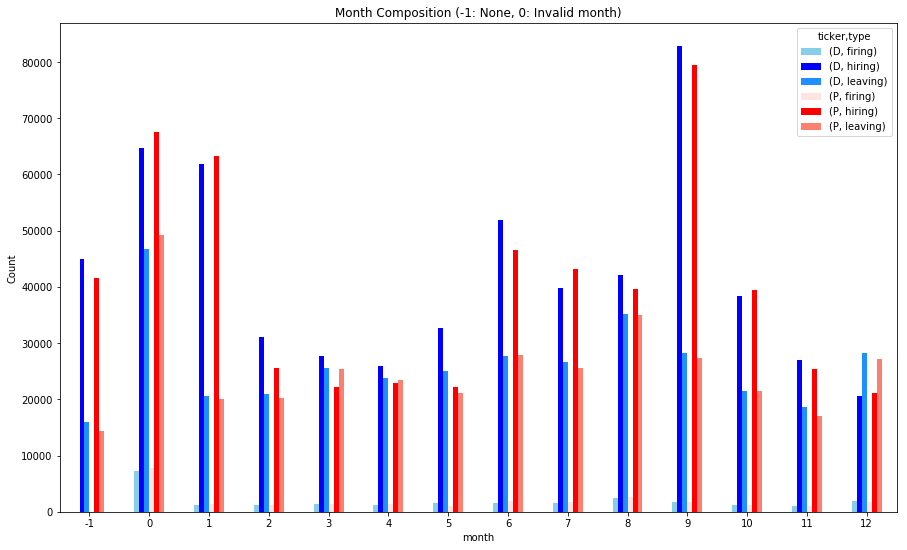

In [14]:
# Month composition.
empl_changes_df.assign(count=1).pivot_table(
    index = 'month', columns = ['ticker','type'], values='count', aggfunc='sum', fill_value=0
).plot.bar(
    figsize=(15,9),color=color_styles,rot=0,
    title="Month Composition (-1: None, 0: Invalid month)"
).set_ylabel("Count")
plt.show()

## By birth group.
Note: Birth year `2000` seems to be a trash bin for problematic records and thus will be treated the same as `None`.

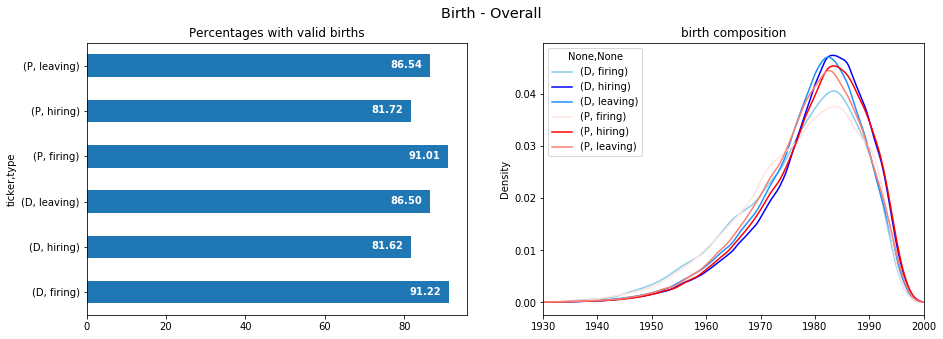

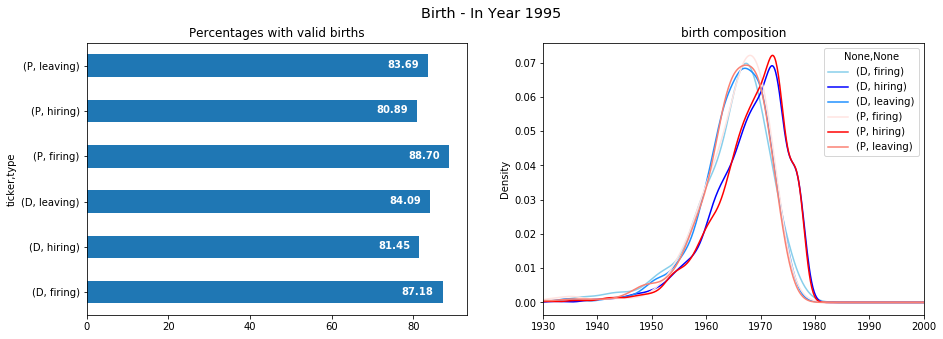

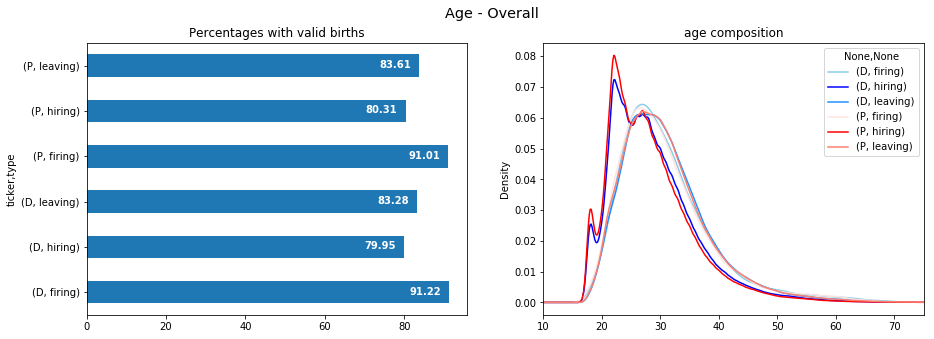

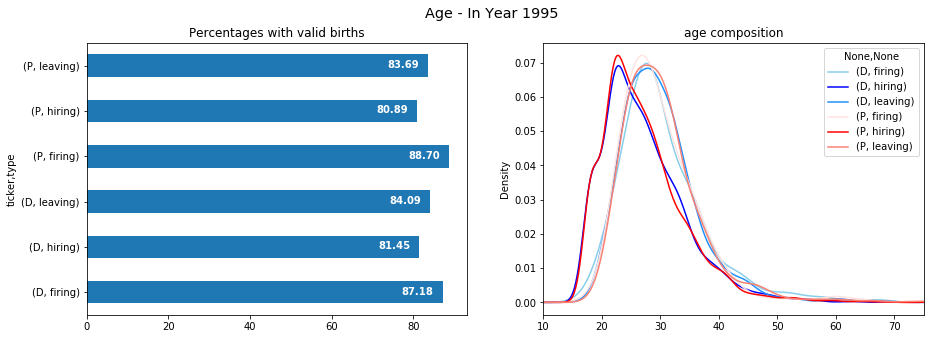

In [15]:
birth_df = empl_changes_df[['ticker','type','year','birth']]
birth_df = birth_df.assign(
    birth = lambda df:df.birth.apply(lambda x:int(x) if x not in ['2000','None'] else np.nan),
    age = lambda df:(df.year-df.birth)
)

# Define a routine to generate plots.
def birth_plot(DF,var,title,xlim=None):
    plt.subplots(1,2,figsize=(15,5))
    plt.suptitle(title,fontsize="x-large")
    plt.subplot(121)
    to_plot = DF.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(DF.loc[~DF[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="{} composition".format(var),color=color,legend=True)
    plt.show()
    
birth_plot(birth_df,'birth',"Birth - Overall",(1930,2000))
birth_plot(birth_df.loc[birth_df.year==1995],'birth',"Birth - In Year 1995",(1930,2000))
birth_plot(birth_df,'age',"Age - Overall",(10,75))
birth_plot(birth_df.loc[birth_df.year==1995],'age',"Age - In Year 1995",(10,75))

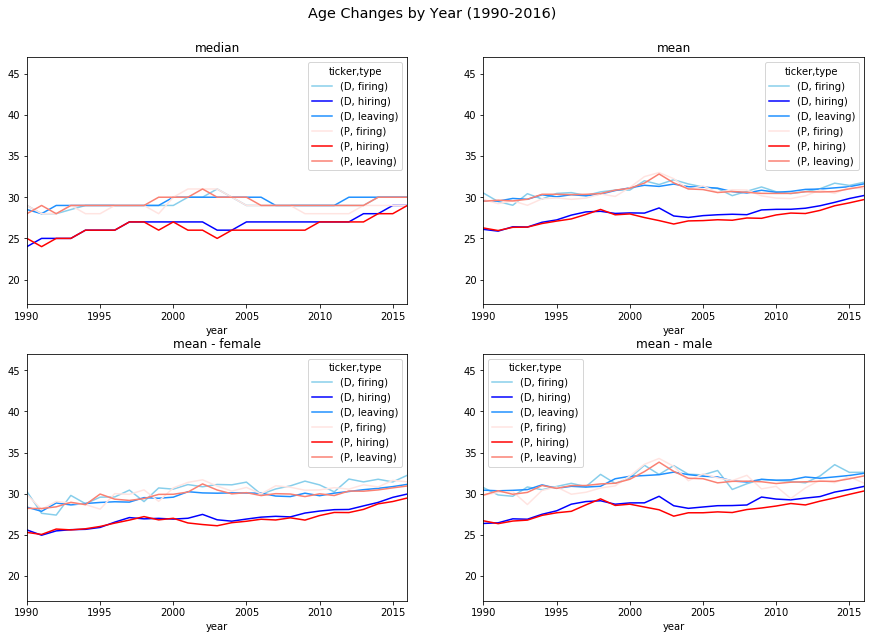

In [16]:
# Age changes by year.
fig, ((ax11, ax12), (ax21, ax22))=plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Age Changes by Year (1990-2016)',fontsize='x-large',y=0.95)
birth_df.pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='median'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax11,title='median')
birth_df.pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax12,title='mean')
birth_df.loc[empl_changes_df.gender=='1'].pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax21,title='mean - female')
birth_df.loc[empl_changes_df.gender=='2'].pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax22,title='mean - male')
plt.show()

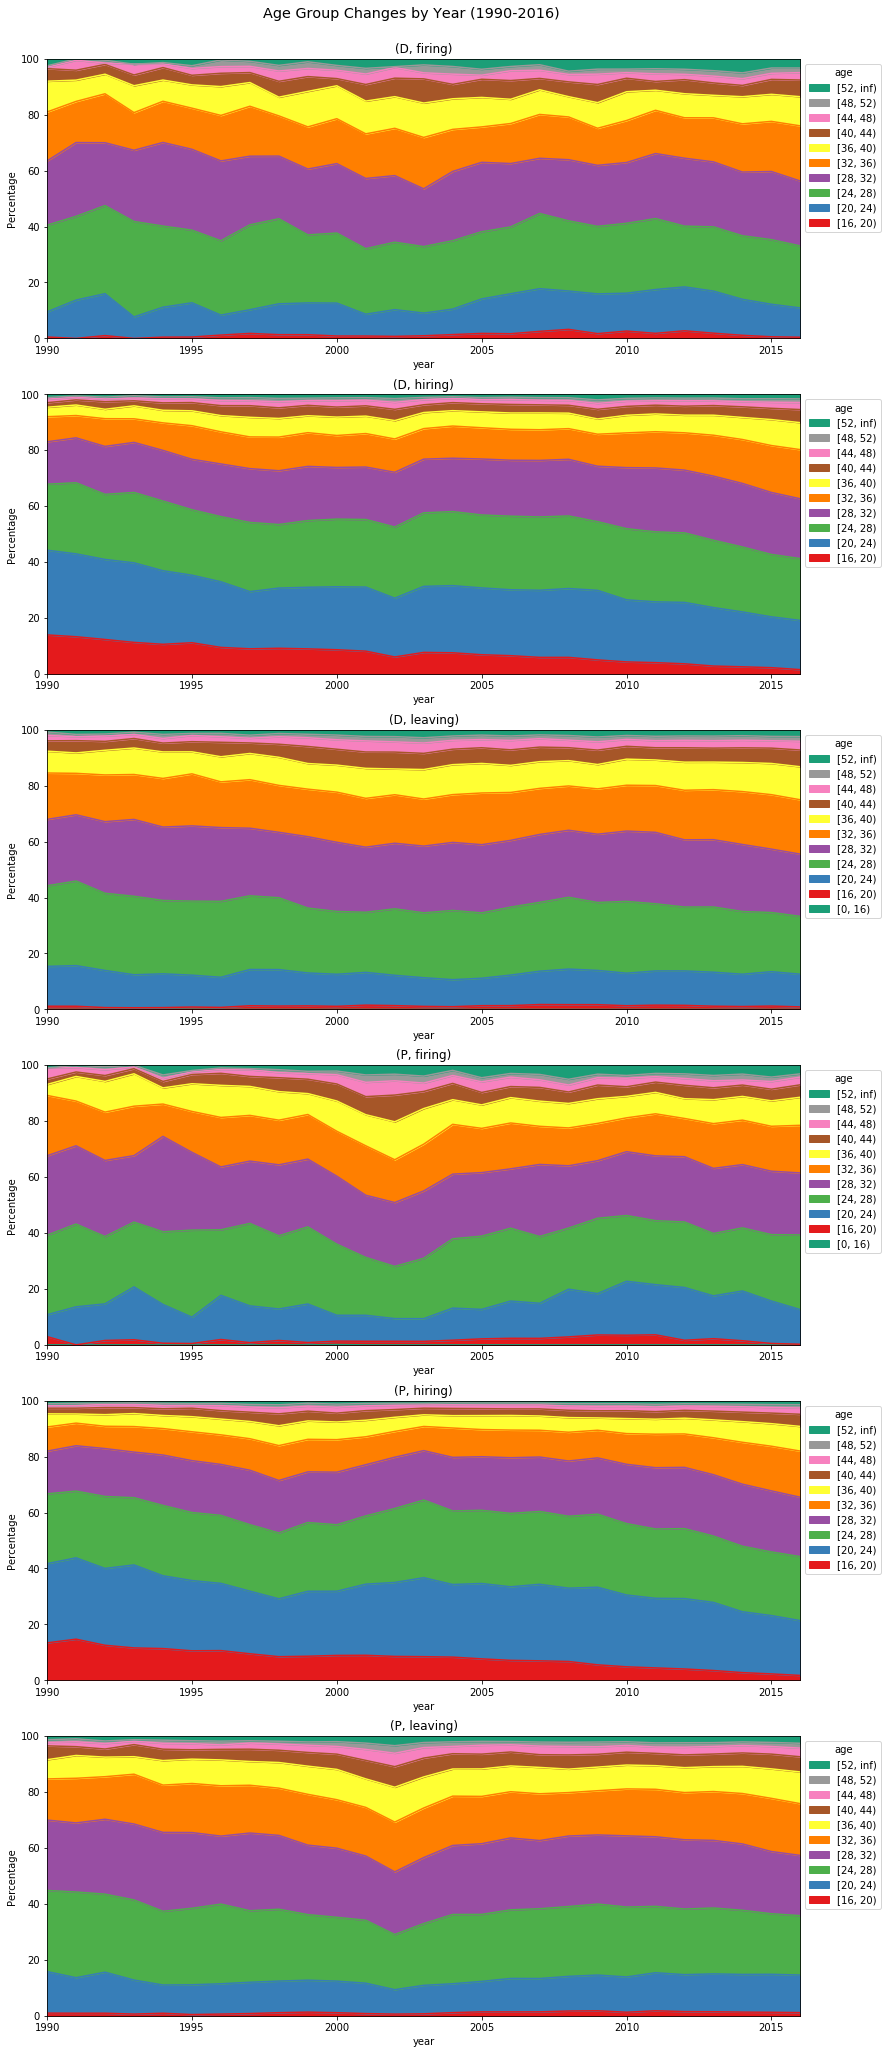

In [17]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Age Group Changes by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','age']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=pd.cut(grp.age, bins, right=False, labels=False), values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),
        color=[colormap_unif[int(float(i))] for i in to_plot.columns]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title='age'
    )
plt.show()

## By Gender.

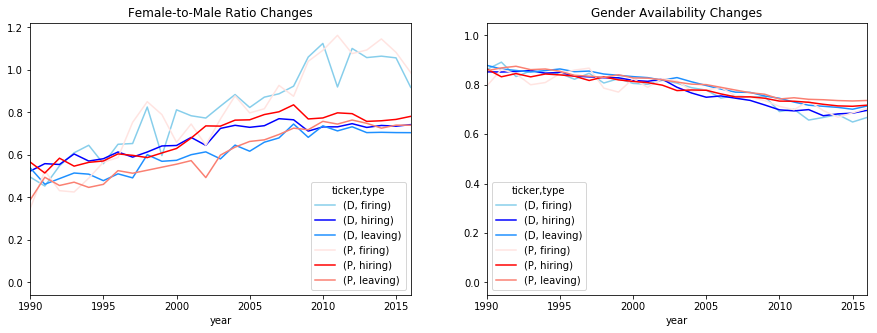

In [18]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='gender',
    aggfunc=lambda x:((x=='1').sum()/(x=='2').sum() if (x=='2').sum() else np.nan)
).plot(xlim=(1990,2016),color=color_styles,title="Female-to-Male Ratio Changes",ax=ax1)
empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='gender',
    aggfunc=lambda x:((x!='0').sum()/x.size)
).plot(xlim=(1990,2016),color=color_styles,title="Gender Availability Changes",ax=ax2)
plt.show()

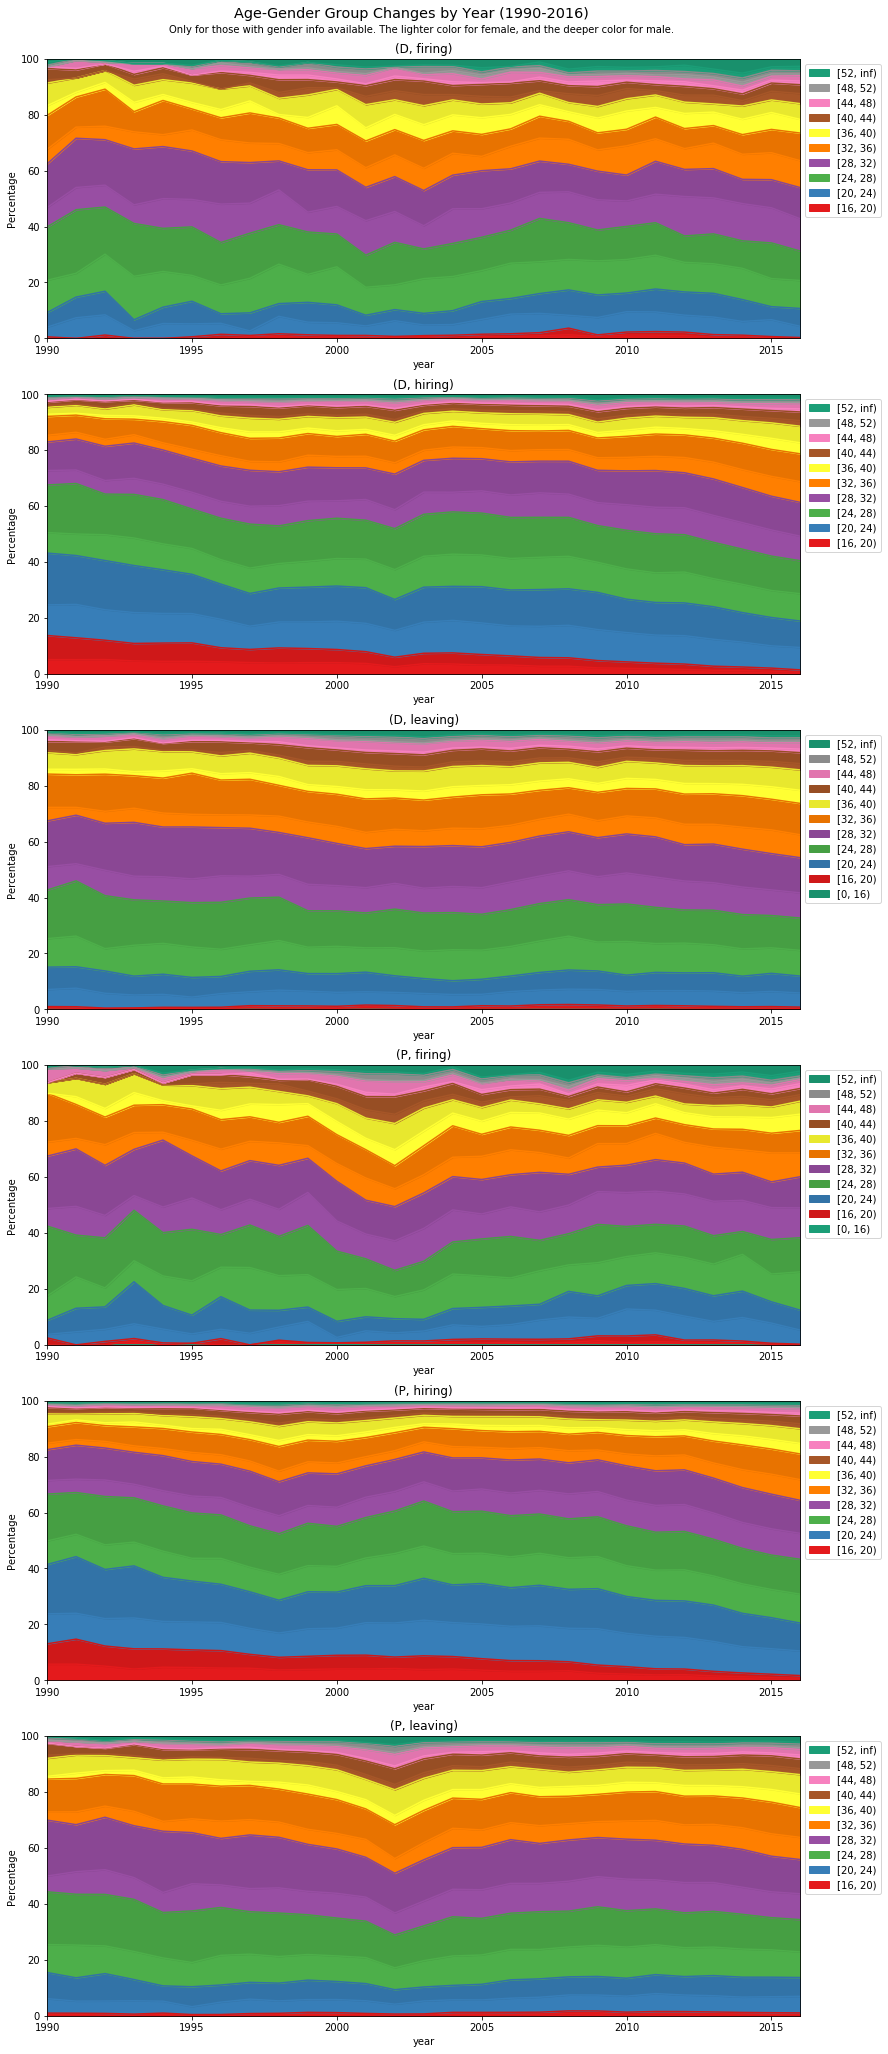

In [19]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Age-Gender Group Changes by Year (1990-2016)", fontsize='x-large', y=0.90)
fig.text(0.25,0.89,
         "Only for those with gender info available. The lighter color for female, and the deeper color for male.")
for (idx, grp), ax in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(empl_changes_df.gender!='0'), ['ticker','type','year','age']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=[pd.cut(grp.age, bins, right=False, labels=False), empl_changes_df.gender], 
        values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),
        color=[
            colormap_unif[int(float(i))] if j=='1' else tuple(t/1.1 for t in colormap_unif[int(float(i))]) 
            for i,j in to_plot.columns
        ]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed([handles[i] for i in range(len(handles)) if i%2==0]), 
        reversed(["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in
            [re.match(r"\((\d+)\.0",labels[i]).group(1) for i in range(len(labels)) if i%2==0]
        ]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Primary Skill.

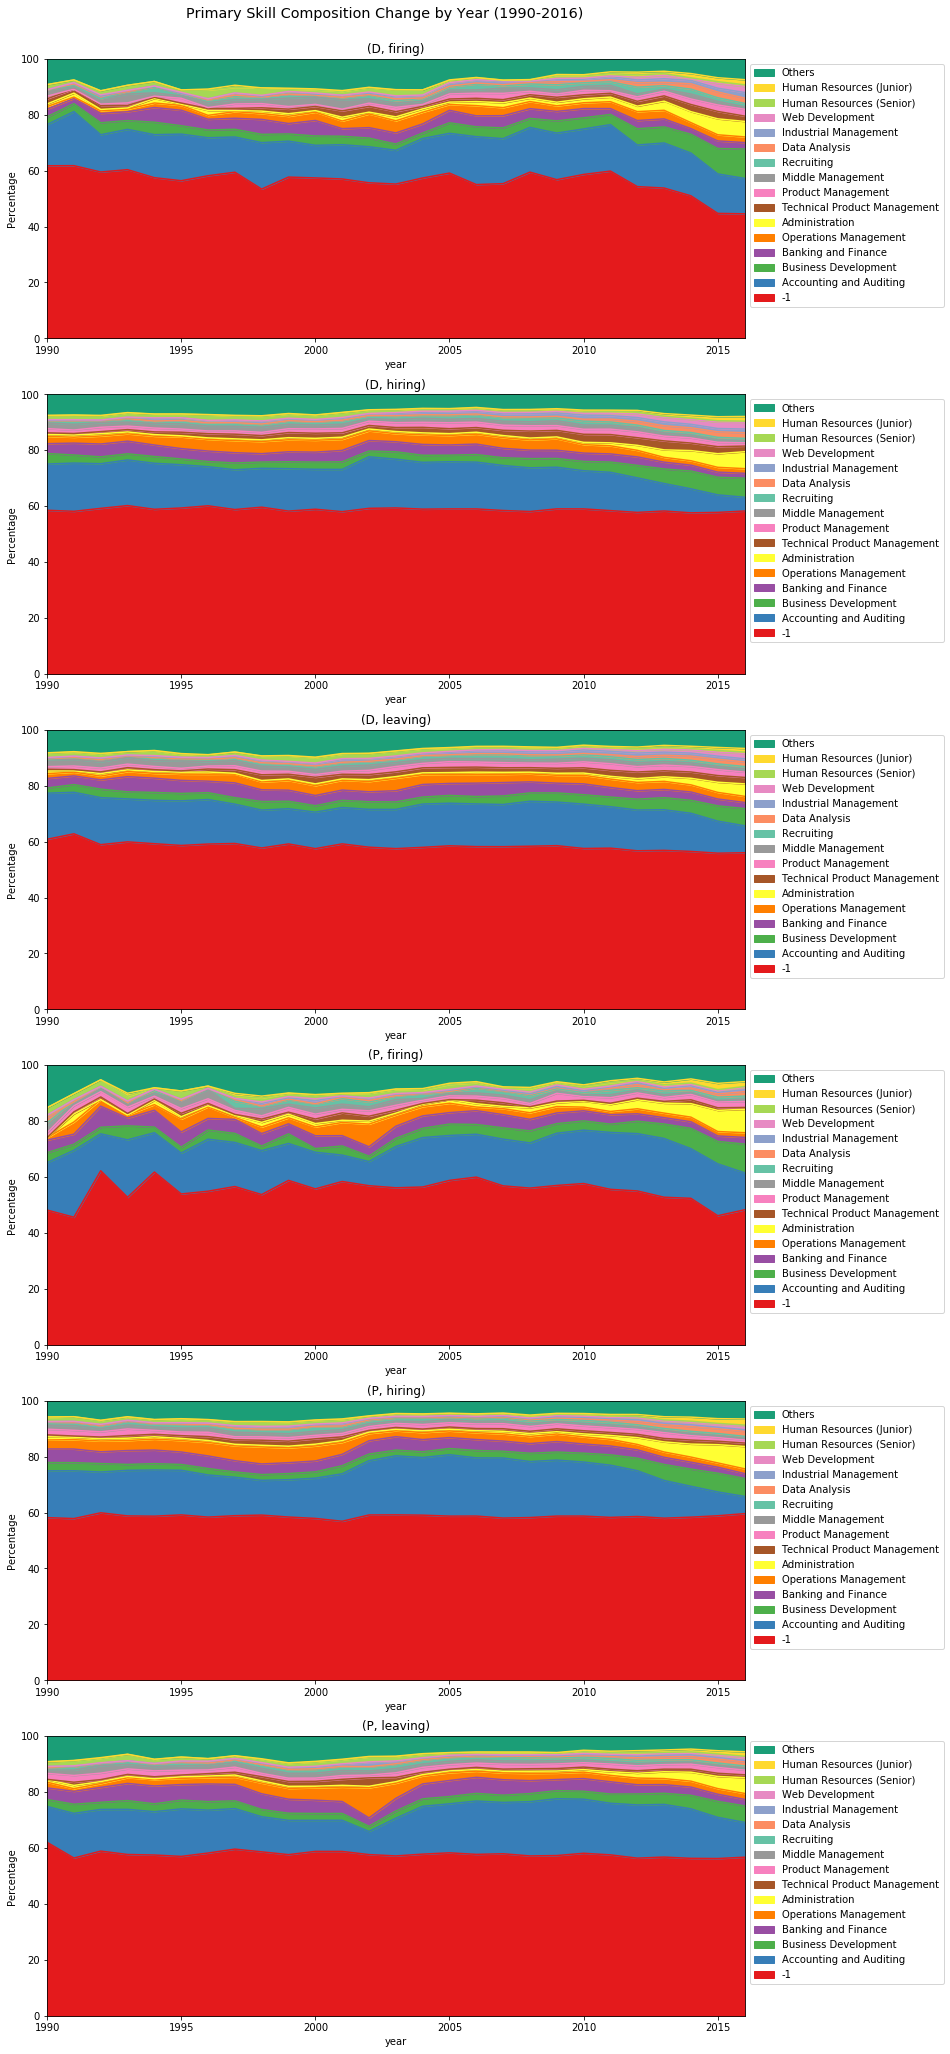

In [26]:
# Create a uniform colormap for all subplots.
skill1_ord_unif = empl_changes_df.groupby('skill1').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill1_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# fig.suptitle("Secondary Skill Composition",fontsize='x-large')
# for (idx,col),ax in zip(
#     empl_changes_df.loc[:].pivot_table(
#         index='skill1',columns=['ticker','type'],values='gender',aggfunc='count'
#     ).iteritems(), itertools.chain.from_iterable(axs)
# ):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:18]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     ax=to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,
#         colors = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(12.5,36))
fig.suptitle("Primary Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill1']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        skill1_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill1_ord_unif)}[x] for x in df.skill1
        ], count = 1
    ).pivot_table(
        index='year', columns='skill1_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = skill1_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Country.

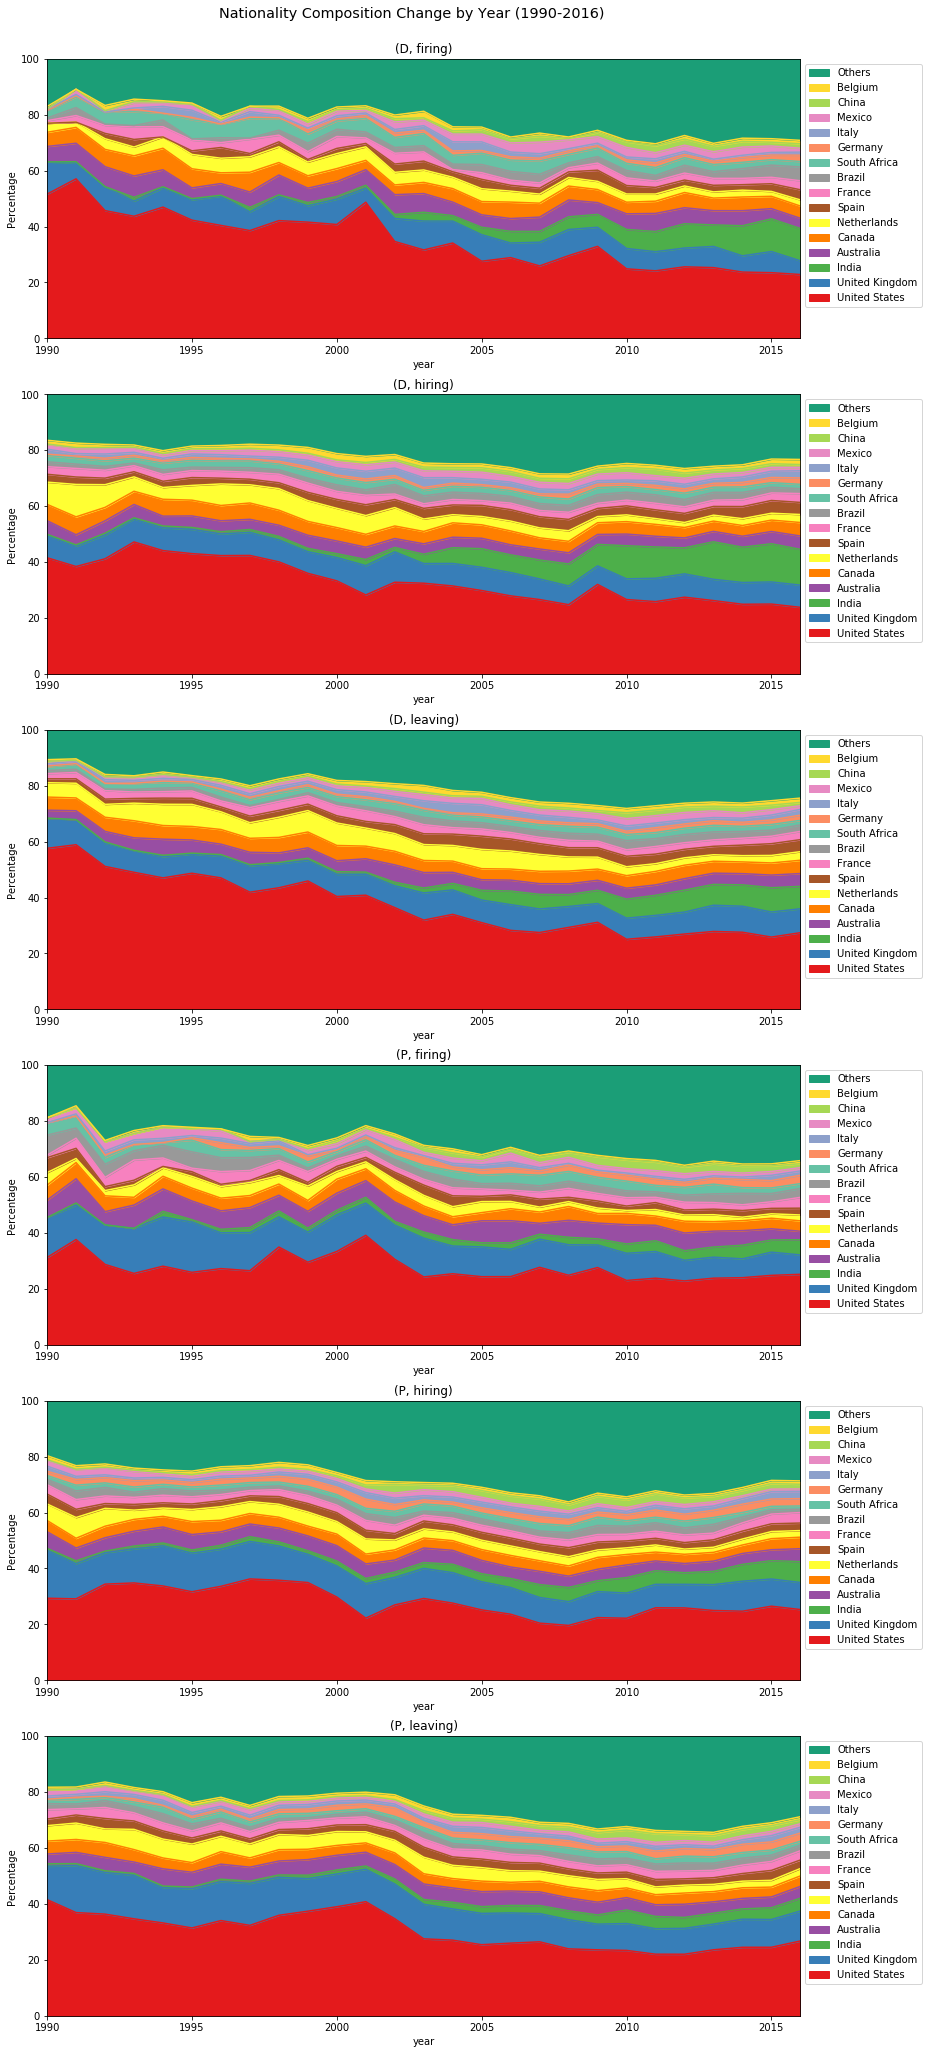

In [21]:
# Create a uniform colormap for all subplots.
cntry_ord_unif = empl_changes_df.groupby('cntry').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    cntry_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='cntry',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:28]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,rotatelabels=True,
#         color = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()


## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Nationality Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','cntry']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        cntry_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(cntry_ord_unif)}[x] for x in df.cntry
        ], count = 1
    ).pivot_table(
        index='year', columns='cntry_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = cntry_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(labels), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Education Level.

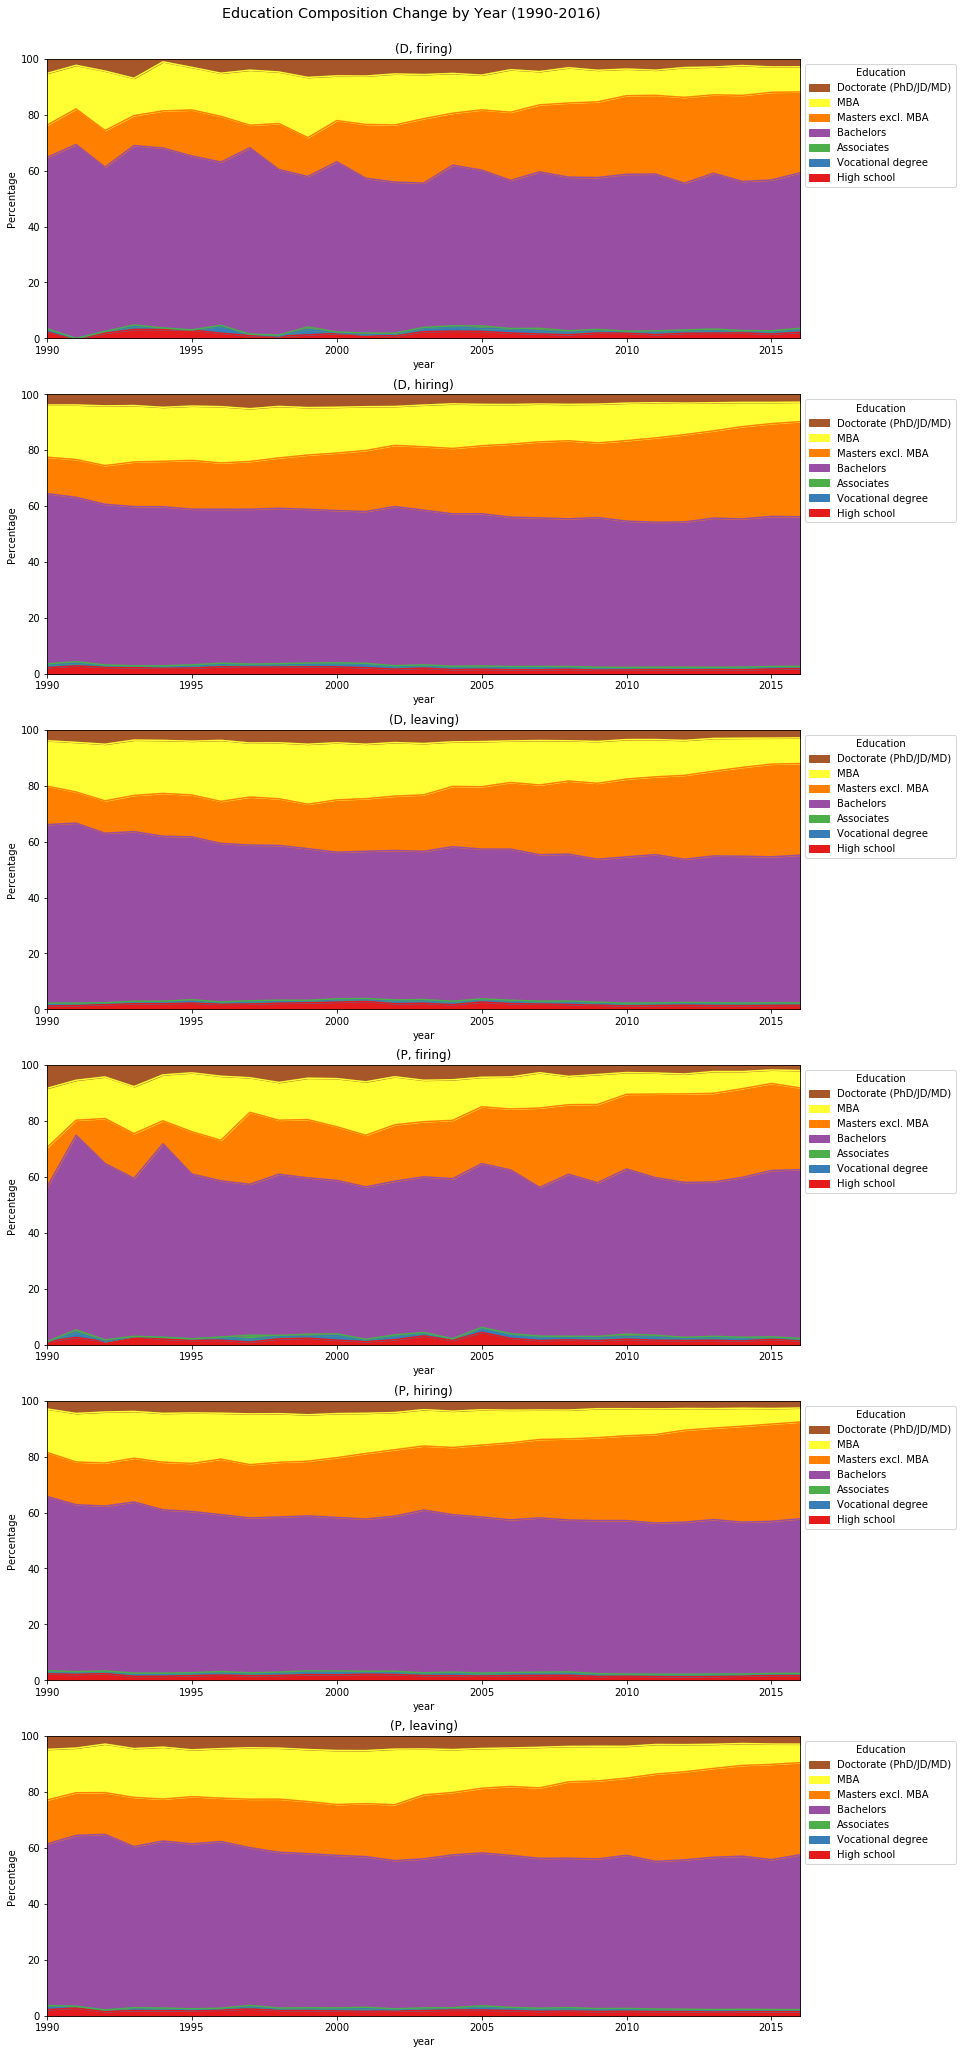

In [22]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}
colormap_unif = {str(idx):clr for idx, clr in zip(
    range(len(edu_lablst)),
    itertools.cycle([plt.get_cmap('Dark2').colors[0]]+list(plt.get_cmap('Set1').colors))
)}

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='edu',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[edu_lablst[x] for x in range(0,8)]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Education Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','edu']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.loc[lambda df:[int(x)>=f_none_hidden for x in df.edu]].assign(count = 1).pivot_table(
        index='year', columns='edu', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), [edu_lablst[int(x)] for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title="Education"
    )
plt.show()



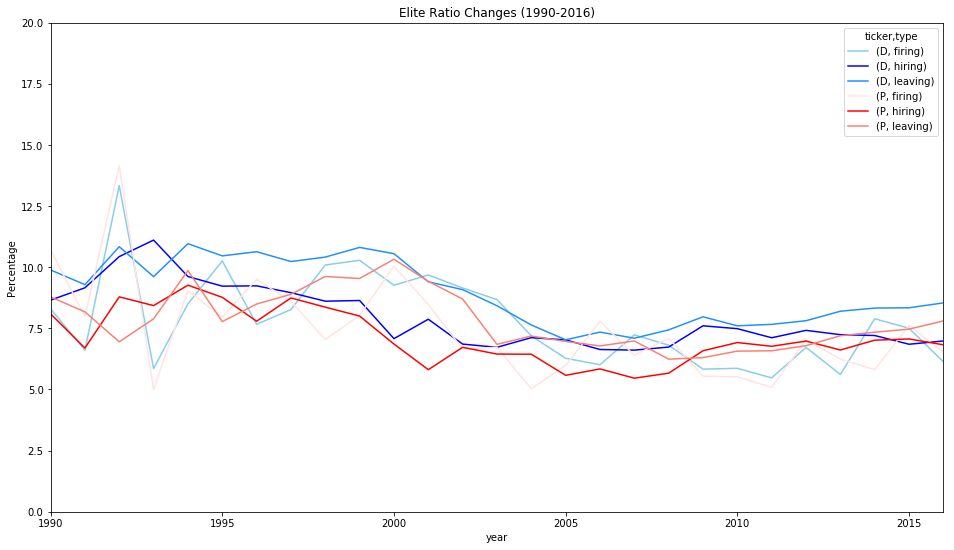

In [27]:
ax = empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='f_elite',
    aggfunc=lambda x:((x=='True').sum()/(x==x).sum()*100)
).plot(
    xlim=(1990,2016),ylim=(0,20),color=color_styles,
    title="Elite Ratio Changes (1990-2016)",figsize=(16,9)
)
ax.set_ylabel('Percentage')
plt.show()

# By Next Industry.

Note: Division of 2-digit NAICS's into industry groups are obtained from [Bureau of Labor Statistics](https://www.bls.gov/iag/tgs/iag_index_naics.htm).

In [24]:
NAICS2GRP_dict = {
    '11': (1, "Natural Resources and Mining"),
    '21': (1, "Natural Resources and Mining"),
    '23': (2, "Construction"),
    '31': (3, "Manufacturing"),
    '32': (3, "Manufacturing"),
    '33': (3, "Manufacturing"),
    '42': (4, "Trade, Transportation, and Utilities"),
    '44': (4, "Trade, Transportation, and Utilities"),
    '45': (4, "Trade, Transportation, and Utilities"),
    '48': (4, "Trade, Transportation, and Utilities"),
    '49': (4, "Trade, Transportation, and Utilities"),
    '22': (4, "Trade, Transportation, and Utilities"),
    '51': (5, "Information"),
    '52': (6, "Financial Activities"),
    '53': (6, "Financial Activities"),
    '54': (7, "Professional and Business Services"),
    '55': (7, "Professional and Business Services"),
    '56': (7, "Professional and Business Services"),
    '61': (8, "Education and Health Services"),
    '62': (8, "Education and Health Services"),
    '71': (9, "Leisure and Hospitality"),
    '72': (9, "Leisure and Hospitality"),
    '81': (10, "Other Services"),
    '92': (11, "Public Administration"),
    '99': (12, "Unknown/Unclassified"),
    ''  : (12, "Unknown/Unclassified"),
    'MI': (12, "Unknown/Unclassified"),
    '46': (12, "Unknown/Unclassified")
}

# Show the mappings.
pd.DataFrame(
    [[key, value[0], value[1]] for key,value in NAICS2GRP_dict.items()]
).groupby([1,2])[0].apply(lambda ser:', '.join(ser)).reset_index().drop(1,axis=1).rename(
    {2:"Industry group",0:"NAICS2"},axis=1
)

Industry group                  NAICS2
0           Natural Resources and Mining                  11, 21
1                           Construction                      23
2                          Manufacturing              31, 32, 33
3   Trade, Transportation, and Utilities  42, 44, 45, 48, 49, 22
4                            Information                      51
5                   Financial Activities                  52, 53
6     Professional and Business Services              54, 55, 56
7          Education and Health Services                  61, 62
8                Leisure and Hospitality                  71, 72
9                         Other Services                      81
10                 Public Administration                      92
11                  Unknown/Unclassified            99, , MI, 46

Note: `46` seems to be a wrong NAICS2 code.

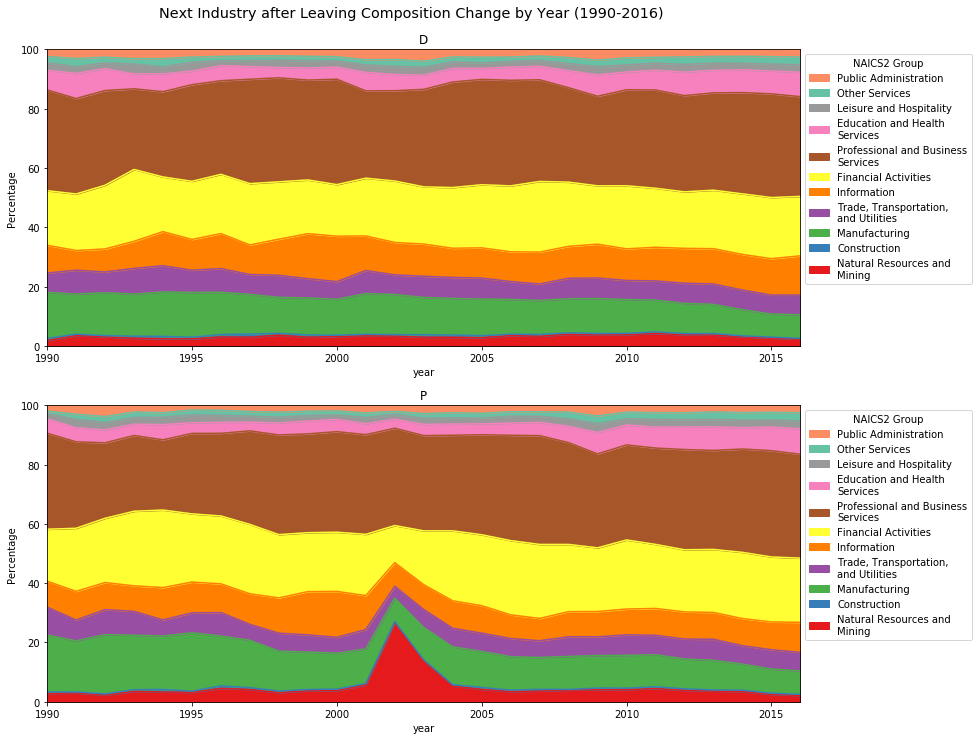

In [25]:
ind_next_lst = sorted(list(set(NAICS2GRP_dict.values())))
colormap_unif = {idx:clr for idx, clr in zip(
    ind_next_lst[:-1], # Assume the last element is "Others".
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif[ind_next_lst[-1]] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(1,2,figsize=(15,7.5))
# for (idx,col),ax in zip(empl_changes_df.loc[lambda df:df.type=='leaving'].pivot_table(
#     index=empl_changes_df.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
#     columns='ticker', values='gender', aggfunc='count'
# ).iteritems(),axs):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[x[1] for x in col.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
fig, axs = plt.subplots(2,1,figsize=(13.5,12))
fig.suptitle("Next Industry after Leaving Composition Change by Year (1990-2016)", fontsize='x-large', y=0.93)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(df.type=='leaving'), ['ticker','type','year','ind_next']
    ].groupby('ticker'), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        columns=grp.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
        index='year', values='count', aggfunc='sum', fill_value=0
    )
    if f_none_hidden:
        to_plot.drop(ind_next_lst[-1], axis=1, inplace=True)
    to_plot = to_plot.apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=idx
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["\n".join(wrap(re.match(r"\(\d+, (.+)\)",x).group(1),25)) for x in reversed(labels)], 
        loc='upper left', bbox_to_anchor=(1,1), title="NAICS2 Group"
    )
plt.show()